In [1]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scipy
from scipy import stats

In [2]:
# Functions
# ---------
# Isotopic mass balace equation
def simSr(jr, rr, rsw, jh, rh, n):
    """

    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw)) / n
    return rSr

# Function to run model
def run_sim(nt, dt, age, jr, rr, rsw, jh, rh, n):
    """
    
    Run strontium isotopic mass balance.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0])/(jr[0]+jh[0])
    rsw[0] = rsw0
    
    for i in range(nt-1):
        rsw[i+1] = rsw[i] + simSr(jr[i], rr[i], rsw[i], jh[i], rh[i], n[i])*dt
    
    grad1 = np.diff(rsw)/np.diff(age)
    grad1 = np.append(grad1, grad1[-1])
    grad2 = np.diff(grad1) / np.diff(age)
    grad2 = np.append(grad2, grad2[-1])
    
    return rsw, grad1

### Define time
This block of code creates arrays to run the simulation.

In [3]:
# Define array of time
# --------------------
tmin = 487      # ~ base of Ordovician in Ma (GTS2020)
tmax = 443      # ~ base of Silurian in Ma (GST2020)
nt = 100000     # number of steps
dt = (tmin - tmax)*1e6 / nt    # size of each step
time = np.linspace(0, (tmin-tmax)*1e6, nt)    # time array
age = np.linspace(tmin, tmax, nt)             # age array (in Myr)

In [4]:
# Initial values and parameters
# -----------------------------
# Riverine flux
Jriv0 = 2.5e10
Jriv = np.ones(nt) * Jriv0

# Riverine isotopic ratio
Rriv0 = 0.7119
Rriv = np.ones(nt) * Rriv0

# Hydrothermal flux
Jh0 = 1.25e10
Jh = np.ones(nt) * Jh0

# Hydrothermal isotopic ratio
Rh0 = 0.7030
Rh = np.ones(nt) * Rh0

# Array to store isotopic ratio of seawater and rate of change
Rsw = np.zeros(nt)
GradSr = np.zeros(nt)

# Reservoir size
N = np.ones(nt) * 1.9e17

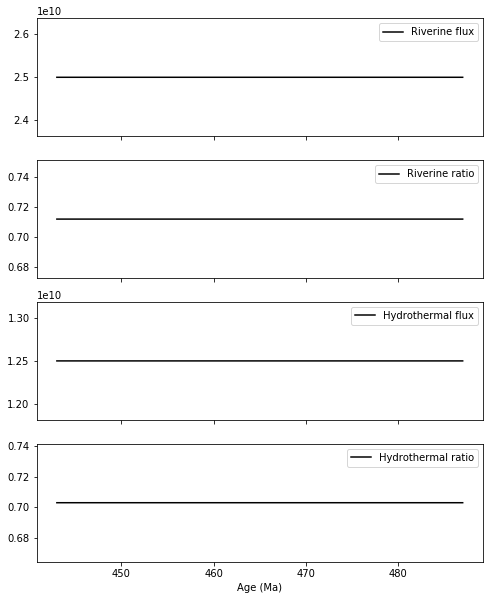

In [5]:
fig, ax = plt.subplots(4, figsize=(8,10), sharex=True)

params = {
    'Riverine flux':Jriv, 
    'Riverine ratio':Rriv, 
    'Hydrothermal flux':Jh, 
    'Hydrothermal ratio':Rh}

for index, (key, value), in enumerate(params.items()):
    ax[index].plot(age, value, c='k',label=key)
    ax[index].legend(loc='upper right')
    ax[-1].set_xlabel('Age (Ma)')

#plt.savefig("../Figure/params.png")
#plt.savefig("../Figure/params.svg")

slope 1: 1.5084297298000178e-05
slope 2: 8.074912492572909e-05


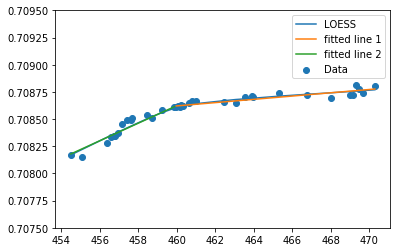

In [6]:
# Simplify two parts of LOESS curve into lines
# -------------------
# Import LOESS curve as reference
SrOrdo = pd.read_csv('Srloess_R.csv')

# Isolate LOESS data sets and convert to np
Rloess = SrOrdo['loess'].to_numpy()
Rage = SrOrdo['age'].to_numpy()

#Define and use the point of inflection
inflec = 460
diff = abs(inflec-Rage)
diff_index = np.where(diff == diff.min())[0][0]

# First line
first_sr = Rloess[diff_index:]
first_age = Rage[diff_index:]
line1 = scipy.stats.linregress(first_age, first_sr)

# Second line
second_sr = Rloess[:diff_index]
second_age = Rage[:diff_index]
line2 = scipy.stats.linregress(second_age, second_sr)

plt.scatter(SrOrdo['age'], SrOrdo['sr'], label='Data')
plt.plot(SrOrdo['age'], SrOrdo['loess'], label='LOESS')
plt.plot(first_age, line1.intercept + line1.slope*first_age, label='fitted line 1')
plt.plot(second_age, line2.intercept + line2.slope*second_age, label='fitted line 2')
plt.legend(loc='best')
plt.ylim(0.7075, 0.7095)

print('slope 1:',line1.slope)
print('slope 2:',line2.slope)

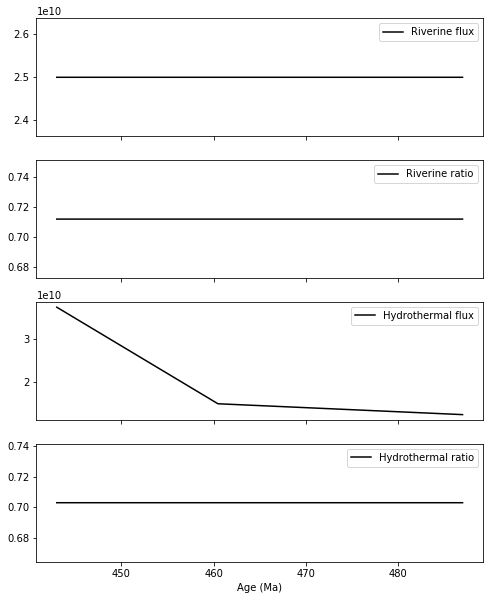

In [7]:
#Build Jh

#convert age to array index
point = np.where(np.round(age)==inflec)[0][0]

#define two different rates
f1 = 1.2
Jh[:point] = np.linspace(Jh0, Jh0*f1, point)
f2 = 3
Jh[point:] = np.linspace(Jh[point-1], Jh0*f2, len(Jh)-point)

#plots
params = {
    'Riverine flux':Jriv, 
    'Riverine ratio':Rriv, 
    'Hydrothermal flux':Jh,
    'Hydrothermal ratio':Rh}

fig, ax = plt.subplots(len(params), figsize=(8,10), sharex=True)
for index, (key, value), in enumerate(params.items()):
    ax[index].plot(age, value, c='k',label=key)
    ax[index].legend(loc='upper right')
    ax[-1].set_xlabel('Age (Ma)')

In [8]:
# Run the model
# -------------
Rsw, GradSr = run_sim(nt, dt, age, Jriv, Rriv, Rsw, Jh, Rh, N)

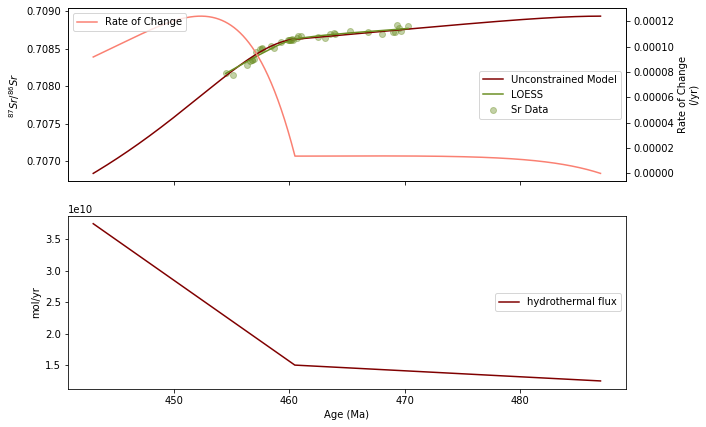

In [9]:
# plot the result
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
ax1.plot(age, Rsw, c='maroon', label="Unconstrained Model")
ax1.plot(SrOrdo['age'], SrOrdo['loess'], c='olivedrab', label='LOESS')
ax1.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Data', alpha=0.4)
ax1.set_ylabel('$^{87}Sr/^{86}Sr$')
ax1.legend(loc='right')

ax1b = ax1.twinx()
ax1b.plot(age, GradSr, color='salmon',label='Rate of Change')
ax1b.set_ylabel('Rate of Change\n(/yr)')
ax1b.legend(loc='upper left')

ax2.plot(age, Jh, c='maroon',label='hydrothermal flux')
ax2.set_ylabel('mol/yr')
ax2.set_xlabel('Age (Ma)')
ax2.legend(loc='right')

# Constraining changes in hydrothermal activities using long-term sea-level change

In this model we hypothesize a role for hydrothermal activities in perturbing global Sr cycles during the Ordovician. To model changes in hydrothermal activities we used eustatic sea level curves, assuming the long-term changes in sea levels are mainly controlled by changes in ocean basin geometry, which in turn depends on the rate of sea floor spreading.

Sea level curves were taken from Haq and Schutter (2008), and recalibrated to Geologic Time Scale 2020 (Goldman et al., 2020).


In [10]:
# load sea level data
haqdf = pd.read_csv('longterm_SL.csv')
haqdf.head()

,meter,age
0,128.510638,442.246392
1,134.042553,443.042098
2,136.012608,443.486640
3,141.430260,443.907425
4,146.355398,444.281445


array size = 100000


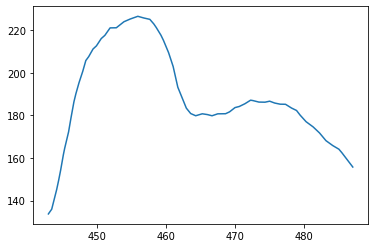

In [11]:
# resample data to fit our modeling array
from scipy import interpolate

f = interpolate.interp1d(haqdf['age'], haqdf['meter'])

sealevel = f(age)
plt.plot(age, sealevel)
print('array size =',len(sealevel))

max  : 1.194468258481344
min  : 0.7049218300296588
mean : 0.9999999999999999


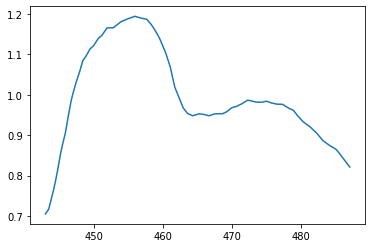

In [12]:
# normalize sea level relative to mean
sl_norm = sealevel / sealevel.mean()

plt.plot(age, sl_norm)
print('max  :', sl_norm.max())
print('min  :', sl_norm.min())
print('mean :', sl_norm.mean())

In [13]:
Jh_sl = sl_norm * Jh0

In [14]:
Rsw_sl = np.zeros(nt)
Rsw_sl, GradSr_sl = run_sim(nt, dt, age, Jriv, Rriv, Rsw_sl, Jh_sl, Rh, N)

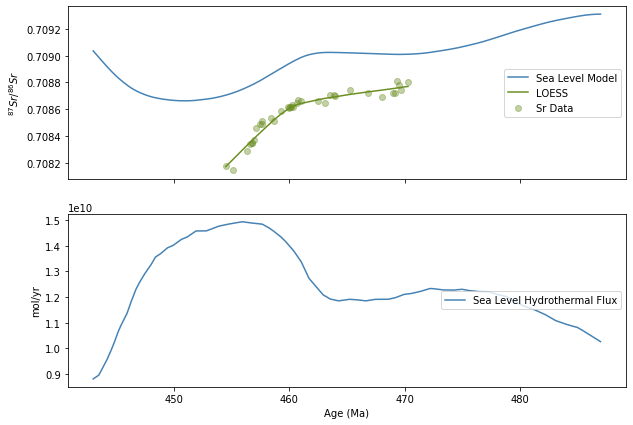

In [15]:
# plot the result
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
ax1.plot(age, Rsw_sl, c='steelblue', label="Sea Level Model")
ax1.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Data', alpha=0.4)
ax1.plot(SrOrdo['age'], SrOrdo['loess'], c='olivedrab', label='LOESS')
ax1.set_ylabel('$^{87}Sr/^{86}Sr$')
ax1.legend(loc='right')

ax2.plot(age, Jh_sl, c='steelblue',label='Sea Level Hydrothermal Flux')
ax2.set_ylabel('mol/yr')
ax2.set_xlabel('Age (Ma)')
ax2.legend(loc='right')


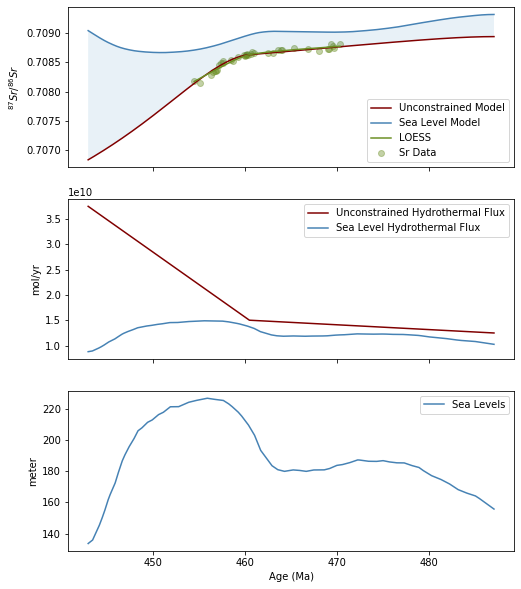

In [16]:
fig, ax = plt.subplots(3, figsize=(8, 10), sharex=True)

ax[0].plot(age, Rsw, c='maroon', label="Unconstrained Model")
ax[0].plot(age, Rsw_sl, c='steelblue', label="Sea Level Model")
ax[0].scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Data', alpha=0.4)
ax[0].plot(SrOrdo['age'], SrOrdo['loess'], c='olivedrab', label='LOESS')
ax[0].fill_between(age, Rsw_sl, Rsw, alpha=0.1)
ax[0].set_ylabel('$^{87}Sr/^{86}Sr$')
ax[0].legend(loc='best')

ax[1].plot(age, Jh, c='maroon',label='Unconstrained Hydrothermal Flux')
ax[1].plot(age, Jh_sl, c='steelblue',label='Sea Level Hydrothermal Flux')
ax[1].set_ylabel('mol/yr')
ax[1].legend(loc='best')

ax[2].plot(age, sealevel, c='steelblue', label='Sea Levels')
ax[2].set_ylabel('meter')
ax[2].set_xlabel('Age (Ma)')
ax[2].legend(loc='best')